<a href="https://colab.research.google.com/github/Dwinurcahyo2/Data-Mining-Lanjut/blob/main/UAS_data_mining_lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UAS DATA MINING LANJUT**

In [ ]:
# src/01_convert_to_csv.py

import os
import wfdb
import pandas as pd
from tqdm import tqdm

# Path base di Google Colab
BASE_DIR = "/content"
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_CSV_DIR = os.path.join(BASE_DIR, 'output', 'csv')

# Daftar dataset dan nama foldernya
DATASETS = {
    'arrhythmia': 'mit-bih-arrhythmia-database-1.0.0',
    'noise': 'mit-bih-noise-stress-test-database-1.0.0'
}

def convert_all_records_to_csv():
    print("Memulai proses konversi data mentah ke CSV...")
    os.makedirs(OUTPUT_CSV_DIR, exist_ok=True)

    all_records_paths = []

    # Kumpulkan semua path rekaman dari kedua dataset
    for db_name, folder_name in DATASETS.items():
        db_path = os.path.join(DATA_DIR, folder_name)
        if not os.path.isdir(db_path):
            print(f"Peringatan: Folder dataset '{folder_name}' tidak ditemukan di '{DATA_DIR}'.")
            continue

        # Cari semua file .hea untuk mendapatkan nama rekaman
        records = [f.replace('.hea', '') for f in os.listdir(db_path) if f.endswith('.hea')]
        for rec in records:
            all_records_paths.append({
                'path': os.path.join(db_path, rec),
                'name': rec,
                'db': db_name
            })

    if not all_records_paths:
        print("Tidak ada rekaman yang ditemukan. Pastikan data sudah diekstrak ke folder 'data'.")
        return

    print(f"Ditemukan {len(all_records_paths)} total rekaman untuk diproses.")

    for record_info in tqdm(all_records_paths, desc="Mengonversi ke CSV"):
        try:
            record_path = record_info['path']
            record_name = record_info['name']

            # Membaca sinyal dan metadata
            signals, fields = wfdb.rdsamp(record_path)

            # Membuat DataFrame
            df = pd.DataFrame(signals, columns=fields['sig_name'])

            # Menyimpan ke CSV
            output_filename = f"{record_info['db']}_{record_name}.csv"
            output_path = os.path.join(OUTPUT_CSV_DIR, output_filename)
            df.to_csv(output_path, index=False)

        except Exception as e:
            print(f"Gagal memproses {record_name}: {e}")

    print(f"\nProses konversi selesai. File CSV disimpan di: {OUTPUT_CSV_DIR}")

# Jalankan fungsi
convert_all_records_to_csv()


Memulai proses konversi data mentah ke CSV...
Ditemukan 63 total rekaman untuk diproses.


Mengonversi ke CSV: 100%|██████████| 63/63 [01:19<00:00,  1.26s/it]


Proses konversi selesai. File CSV disimpan di: /content/output/csv


In [ ]:
import zipfile

# Path zip file kedua
noise_zip_path = "/content/data/mit-bih-noise-stress-test-database-1.0.0.zip"
extract_path = "/content/data"

# Ekstrak zip file
with zipfile.ZipFile(noise_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import os

# Buat folder 'data' jika belum ada
os.makedirs("data", exist_ok=True)


Filtering (Preprocessing)

In [ ]:
from scipy.signal import iirnotch, filtfilt
import os
import pandas as pd

# Path ke folder CSV
OUTPUT_CSV_DIR = "/content/output/csv"

# Ambil daftar file CSV
csv_files = [f for f in os.listdir(OUTPUT_CSV_DIR) if f.endswith('.csv')]

if not csv_files:
    print(f"Tidak ada file CSV ditemukan di {OUTPUT_CSV_DIR}. Harap jalankan sel konversi terlebih dahulu.")
else:
    # Pilih salah satu file CSV untuk contoh
    sample_csv_path = os.path.join(OUTPUT_CSV_DIR, csv_files[0])
    print(f"Menggunakan file CSV contoh: {sample_csv_path}")

    # Membaca file CSV
    df_sample = pd.read_csv(sample_csv_path)

    # Pilih kolom sinyal untuk filtering (misal kolom pertama)
    if not df_sample.empty and len(df_sample.columns) > 0:
        original_signal = df_sample.iloc[:, 0].values # Ambil data dari kolom pertama sebagai numpy array
        print(f"Memuat sinyal dengan {len(original_signal)} sampel.")

        # Notch filter untuk menghilangkan 50 Hz (PLI)
        fs = 360  # sampling rate (sesuai metadata MIT-BIH)
        f0 = 50  # frekuensi derau (Power Line Interference)
        Q = 30  # kualitas filter
        b, a = iirnotch(f0, Q, fs)

        # Melakukan filtering
        filtered_signal = filtfilt(b, a, original_signal)

        print("Filtering selesai.")
        # Sekarang 'filtered_signal' berisi sinyal yang sudah difilter
        # Anda bisa menampilkan atau menganalisis 'filtered_signal'

    else:
        print(f"File CSV {sample_csv_path} kosong atau tidak memiliki kolom.")

Menggunakan file CSV contoh: /content/output/csv/noise_118e12.csv
Memuat sinyal dengan 650000 sampel.
Filtering selesai.


Ekstraksi Ciri Derau

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_features(signal, fs=360):
    """
    Mengekstrak fitur-fitur dari segmen sinyal EKG.
    Menambahkan fitur statistik dasar: energy, variance, skewness, kurtosis, zero-crossing rate, dan spectrum peak.
    """
    # Pastikan sinyal adalah numpy array
    if not isinstance(signal, np.ndarray):
        signal = np.asarray(signal)

    # Pastikan sinyal tidak kosong dan memiliki nilai valid
    if len(signal) == 0 or not np.isfinite(signal).all():
        # Return default values or NaNs for invalid signals
        return {
            "energy": np.nan,
            "variance": np.nan,
            "skewness": np.nan,
            "kurtosis": np.nan,
            "zero_crossing_rate": np.nan,
            "spectrum_peak": np.nan
        }

    # Fitur berbasis waktu
    energy = np.sum(signal**2)
    variance = np.var(signal)
    skewness_val = skew(signal) # Skewness
    kurtosis_val = kurtosis(signal) # Kurtosis (Fisher's definition, kurtosis of normal distribution is 0)

    # Zero-crossing rate
    # Menghitung berapa kali sinyal melewati nol, dibagi dengan panjang sinyal
    zero_crossing_rate_val = np.sum(np.diff(np.sign(signal) != 0).astype(int)) / len(signal)


    # Fitur berbasis frekuensi
    try:
        freq_spectrum = np.abs(np.fft.fft(signal))
        # Ambil hanya frekuensi positif
        freq_spectrum_positive = freq_spectrum[:len(freq_spectrum)//2]
        # Hindari argmax pada array kosong jika sinyal terlalu pendek
        if len(freq_spectrum_positive) > 0:
            spectrum_peak = np.argmax(freq_spectrum_positive) # Index frekuensi dengan magnitudo tertinggi
        else:
            spectrum_peak = np.nan # Atau nilai default lainnya jika spektrum kosong

    except Exception as e:
        print(f"Error saat menghitung spektrum frekuensi: {e}")
        spectrum_peak = np.nan


    return {
        "energy": energy,
        "variance": variance,
        "skewness": skewness_val,
        "kurtosis": kurtosis_val,
        "zero_crossing_rate": zero_crossing_rate_val,
        "spectrum_peak": spectrum_peak # Ini adalah index frekuensi, bukan nilai frekuensi itu sendiri
    }

# Fungsi ini tidak dijalankan secara langsung di sini, hanya didefinisikan.
# Sel berikutnya yang menggunakannya akan memanggil fungsi ini.

Klasifikasi Derau


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
import os # Import os

# --- Start: Data Loading and Splitting (Moved from cell 8ef1eda5) ---
# Path ke file CSV fitur yang sudah diekstrak
INPUT_FEATURES_CSV = "/content/output/features/extracted_features.csv"

# Periksa apakah file fitur ada
if not os.path.exists(INPUT_FEATURES_CSV):
    print(f"File fitur tidak ditemukan di {INPUT_FEATURES_CSV}. Pastikan proses ekstraksi fitur sudah berhasil dijalankan.")
else:
    print(f"Memuat fitur dari: {INPUT_FEATURES_CSV}")
    features_df = pd.read_csv(INPUT_FEATURES_CSV)

    # Pisahkan fitur (X) dan label (y)
    # Kolom fitur adalah 'energy', 'variance', 'spectrum_peak', 'skewness', 'kurtosis', 'zero_crossing_rate'
    # Kolom label adalah 'label'
    # Update kolom fitur sesuai dengan fitur yang diekstraksi
    feature_columns = [col for col in features_df.columns if col not in ['file_name', 'signal_name', 'label']]
    X = features_df[feature_columns]
    y = features_df['label']

    print(f"Ukuran dataset fitur (X): {X.shape}")
    print(f"Ukuran dataset label (y): {y.shape}")

    # Konversi label string (noise/arrhythmia) menjadi numerik menggunakan LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print("\nLabel asli:", y.unique())
    print("Label yang di-encode:", label_encoder.transform(y.unique()))


    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print("\nPembagian data selesai di dalam sel pelatihan.")
    print(f"Ukuran set pelatihan (X_train): {X_train.shape}")
    print(f"Ukuran set pengujian (X_test): {X_test.shape}")
    print(f"Ukuran label pelatihan (y_train_encoded): {y_train_encoded.shape}")
    print(f"Ukuran label pengujian (y_test_encoded): {y_test_encoded.shape}")

    # --- End: Data Loading and Splitting ---

    # --- Start: Model Training ---
    # X_train_used dan y_train_used sekarang diambil langsung dari split di atas
    X_train_used = X_train
    y_train_used = y_train_encoded

    print(f"\nUkuran data pelatihan yang digunakan untuk training: {X_train_used.shape}")
    # Perlu menghitung distribusi kelas pada data yang digunakan untuk pelatihan
    # Jika y_train_used adalah numpy array, gunakan np.bincount
    if isinstance(y_train_used, np.ndarray):
         print(f"Distribusi kelas data pelatihan: {np.bincount(y_train_used)}")
    elif isinstance(y_train_used, pd.Series):
         print(f"Distribusi kelas data pelatihan:\n{y_train_used.value_counts()}")


    # Inisialisasi objek RandomForestClassifier dengan class_weight='balanced'
    # Parameter class_weight='balanced' akan menangani ketidakseimbangan kelas secara otomatis
    clf = RandomForestClassifier(random_state=42, class_weight='balanced')

    # Latih model klasifikasi menggunakan data pelatihan asli (tetapi model memberi bobot pada kelas minoritas)
    clf.fit(X_train_used, y_train_used)

    print("\nModel RandomForestClassifier berhasil dilatih menggunakan class_weight='balanced'.")
    # --- End: Model Training ---

Memuat fitur dari: /content/output/features/extracted_features.csv
Ukuran dataset fitur (X): (126, 6)
Ukuran dataset label (y): (126,)

Label asli: ['noise' 'arrhythmia']
Label yang di-encode: [1 0]

Pembagian data selesai di dalam sel pelatihan.
Ukuran set pelatihan (X_train): (100, 6)
Ukuran set pengujian (X_test): (26, 6)
Ukuran label pelatihan (y_train_encoded): (100,)
Ukuran label pengujian (y_test_encoded): (26,)

Ukuran data pelatihan yang digunakan untuk training: (100, 6)
Distribusi kelas data pelatihan: [76 24]

Model RandomForestClassifier berhasil dilatih menggunakan class_weight='balanced'.


## Preprocessing



In [ ]:
# src/04_split_data.py

from sklearn.model_selection import train_test_split
import pandas as pd
import os


print("Membuat data dummy untuk demonstrasi pembagian data...")

# Jumlah sampel dummy
n_samples = 100

# Jumlah fitur dummy
n_features = 3

# Membuat fitur dummy (misal: energi, variansi, puncak spektrum)
X_dummy = pd.DataFrame(np.random.rand(n_samples, n_features), columns=['energy', 'variance', 'spectrum_peak'])

# Membuat label dummy (misal: 0 untuk 'bukan derau', 1 untuk 'derau')
y_dummy = pd.Series(np.random.randint(0, 2, n_samples), name='noise_label')

X = X_dummy
y = y_dummy
# --- Akhir Bagian Dummy Data ---

print(f"Ukuran dataset fitur (X): {X.shape}")
print(f"Ukuran dataset label (y): {y.shape}")


# Pembagian data menjadi set pelatihan dan pengujian
# Membagi data menjadi 80% pelatihan dan 20% pengujian
# random_state digunakan agar hasil pembagian konsisten setiap kali dijalankan
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nPembagian data selesai.")
print(f"Ukuran set pelatihan (X_train): {X_train.shape}")
print(f"Ukuran set pengujian (X_test): {X_test.shape}")
print(f"Ukuran label pelatihan (y_train): {y_train.shape}")
print(f"Ukuran label pengujian (y_test): {y_test.shape}")

# Sekarang variabel X_train dan y_train sudah terdefinisi dan siap digunakan
# untuk melatih model klasifikasi di sel berikutnya.

Membuat data dummy untuk demonstrasi pembagian data...
Ukuran dataset fitur (X): (100, 3)
Ukuran dataset label (y): (100,)

Pembagian data selesai.
Ukuran set pelatihan (X_train): (80, 3)
Ukuran set pengujian (X_test): (20, 3)
Ukuran label pelatihan (y_train): (80,)
Ukuran label pengujian (y_test): (20,)


## Classification

### Subtask:
Melatih model klasifikasi menggunakan data latih.


**Reasoning**:
Train the Random Forest classifier using the training data.



In [ ]:

clf = RandomForestClassifier(random_state=42) # Menambahkan random_state untuk hasil yang konsisten

# Latih model klasifikasi menggunakan data pelatihan
clf.fit(X_train, y_train)

print("Model RandomForestClassifier berhasil dilatih.")

Model RandomForestClassifier berhasil dilatih.


## Testing & evaluation

### Subtask:
Menguji model yang sudah dilatih menggunakan data uji dan mengevaluasi performanya.


In [ ]:
import os

OUTPUT_CSV_DIR = "/content/output/csv"

# Ambil daftar file CSV
csv_files = [f for f in os.listdir(OUTPUT_CSV_DIR) if f.endswith('.csv')]

if not csv_files:
    print(f"Tidak ada file CSV ditemukan di {OUTPUT_CSV_DIR}. Pastikan proses konversi data mentah ke CSV sudah berhasil dijalankan.")
else:
    print(f"Ditemukan {len(csv_files)} file CSV di {OUTPUT_CSV_DIR}. Berikut adalah beberapa contoh nama file:")
    # Tampilkan 10 nama file pertama sebagai contoh
    for i, file_name in enumerate(csv_files[:10]):
        print(file_name)

Ditemukan 63 file CSV di /content/output/csv. Berikut adalah beberapa contoh nama file:
noise_118e12.csv
noise_118e_6.csv
arrhythmia_219.csv
noise_em.csv
arrhythmia_202.csv
noise_118e24.csv
arrhythmia_123.csv
arrhythmia_215.csv
noise_119e_6.csv
arrhythmia_207.csv


In [ ]:
from scipy.signal import iirnotch, filtfilt, butter
import os
import pandas as pd
from tqdm import tqdm

# Path ke folder CSV input dan output untuk filtered data
INPUT_CSV_DIR = "/content/output/csv"
OUTPUT_FILTERED_CSV_DIR = "/content/output/filtered_csv"

# Buat direktori output jika belum ada
os.makedirs(OUTPUT_FILTERED_CSV_DIR, exist_ok=True)

# Parameter Filter
fs = 360  # sampling rate (sesuai metadata MIT-BIH)

# Notch filter untuk menghilangkan 50 Hz (PLI)
f0_notch = 50  # frekuensi derau (Power Line Interference)
Q_notch = 30  # kualitas filter
b_notch, a_notch = iirnotch(f0_notch, Q_notch, fs)

# High-pass filter untuk mengurangi Baseline Wander
cutoff_high = 0.5  # frekuensi cut-off (Hz)
order_high = 5    # orde filter
# Normalisasi frekuensi cut-off ke skala Nyquist (0 hingga 1, di mana 1 adalah Nyquist frequency fs/2)
nyquist = 0.5 * fs
normal_cutoff_high = cutoff_high / nyquist
b_high, a_high = butter(order_high, normal_cutoff_high, btype='high', analog=False)

# Low-pass filter untuk mengurangi Muscle Noise/derau frekuensi tinggi
cutoff_low = 40  # frekuensi cut-off (Hz)
order_low = 5   # orde filter
normal_cutoff_low = cutoff_low / nyquist
b_low, a_low = butter(order_low, normal_cutoff_low, btype='low', analog=False)


def apply_filters_to_signal(signal, fs, b_high, a_high, b_notch, a_notch, b_low, a_low):
    """
    Menerapkan serangkaian filter (High-pass, Notch, Low-pass) ke sinyal.
    Menggunakan filtfilt untuk zero-phase filtering.
    """
    # Pastikan sinyal bukan NaN atau Inf dan memiliki panjang yang cukup
    if not isinstance(signal, np.ndarray):
        signal = np.asarray(signal)

    if not np.isfinite(signal).all() or len(signal) < max(len(b_high), len(a_high), len(b_notch), len(a_notch), len(b_low), len(a_low)):
         # Handle cases with invalid data or too short signal
         # For simplicity, returning original signal or NaNs, or raising error
         # Let's return the original signal if filtering is not possible
         print("Peringatan: Sinyal tidak valid atau terlalu pendek untuk filtering.")
         return signal # Or return np.full_like(signal, np.nan)


    # Terapkan filter secara berurutan
    # Urutan filter bisa disesuaikan, High-pass -> Notch -> Low-pass adalah urutan umum
    filtered_signal = filtfilt(b_high, a_high, signal)
    filtered_signal = filtfilt(b_notch, a_notch, filtered_signal)
    filtered_signal = filtfilt(b_low, a_low, filtered_signal)

    return filtered_signal


def apply_all_filters_to_file(input_filepath, output_filepath, fs, b_high, a_high, b_notch, a_notch, b_low, a_low):
    """
    Membaca file CSV, menerapkan semua filter ke setiap kolom sinyal,
    dan menyimpan hasilnya ke file CSV baru.
    """
    try:
        df = pd.read_csv(input_filepath)

        # Pastikan DataFrame tidak kosong dan memiliki kolom sinyal
        if df.empty or len(df.columns) == 0:
            print(f"Peringatan: File {input_filepath} kosong atau tidak memiliki kolom. Melewati.")
            return

        # Terapkan filter ke setiap kolom (asumsi semua kolom adalah sinyal)
        df_filtered = df.copy()
        for col in df.columns:
             # Pastikan kolom adalah tipe numerik sebelum filtering
            if pd.api.types.is_numeric_dtype(df[col]):
                signal_data = df[col].values
                # Terapkan semua filter ke sinyal ini
                df_filtered[col] = apply_filters_to_signal(
                    signal_data, fs, b_high, a_high, b_notch, a_notch, b_low, a_low
                )
            else:
                 print(f"Peringatan: Kolom '{col}' di file {input_filepath} bukan numerik. Melewati filtering untuk kolom ini.")


        # Simpan hasil filtering
        df_filtered.to_csv(output_filepath, index=False)

    except Exception as e:
        print(f"Gagal memproses file {input_filepath}: {e}")


# Ambil daftar file CSV dari direktori input
csv_files = [f for f in os.listdir(INPUT_CSV_DIR) if f.endswith('.csv')]

if not csv_files:
    print(f"Tidak ada file CSV ditemukan di {INPUT_CSV_DIR}. Pastikan proses konversi sudah berhasil.")
else:
    print(f"Menerapkan High-pass, Notch, dan Low-pass filter ke {len(csv_files)} file CSV...")
    # Terapkan filtering ke semua file dengan progress bar
    for file_name in tqdm(csv_files, desc="Menerapkan Filtering"):
        input_path = os.path.join(INPUT_CSV_DIR, file_name)
        output_path = os.path.join(OUTPUT_FILTERED_CSV_DIR, file_name)
        apply_all_filters_to_file(
            input_path, output_path, fs, b_high, a_high, b_notch, a_notch, b_low, a_low
        )

    print(f"\nProses filtering selesai. File CSV yang difilter disimpan di: {OUTPUT_FILTERED_CSV_DIR}")

Menerapkan High-pass, Notch, dan Low-pass filter ke 63 file CSV...


Menerapkan Filtering: 100%|██████████| 63/63 [03:05<00:00,  2.95s/it]


Proses filtering selesai. File CSV yang difilter disimpan di: /content/output/filtered_csv


In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Path ke folder CSV yang sudah difilter
INPUT_FILTERED_CSV_DIR = "/content/output/filtered_csv"

# Path untuk menyimpan file CSV fitur
OUTPUT_FEATURES_CSV = "/content/output/features/extracted_features.csv"

# Buat direktori output untuk fitur jika belum ada
os.makedirs(os.path.dirname(OUTPUT_FEATURES_CSV), exist_ok=True)

# Ambil daftar file CSV dari direktori input yang difilter
filtered_csv_files = [f for f in os.listdir(INPUT_FILTERED_CSV_DIR) if f.endswith('.csv')]

if not filtered_csv_files:
    print(f"Tidak ada file CSV yang difilter ditemukan di {INPUT_FILTERED_CSV_DIR}. Pastikan proses filtering sudah berhasil.")
else:
    print(f"Mengekstraksi fitur dari {len(filtered_csv_files)} file CSV yang difilter...")

    all_features = []

    # Iterasi melalui setiap file CSV yang difilter
    for file_name in tqdm(filtered_csv_files, desc="Mengekstraksi Fitur"):
        input_path = os.path.join(INPUT_FILTERED_CSV_DIR, file_name)

        try:
            df_filtered = pd.read_csv(input_path)

            # Tentukan label berdasarkan nama file (misal: 'arrhythmia_' atau 'noise_')
            # Ini adalah asumsi berdasarkan format nama file dari langkah konversi
            label = 'noise' if 'noise_' in file_name else 'arrhythmia'

            # Pastikan DataFrame tidak kosong dan memiliki kolom sinyal
            if df_filtered.empty or len(df_filtered.columns) == 0:
                print(f"Peringatan: File {input_path} kosong atau tidak memiliki kolom. Melewati.")
                continue

            # Ekstraksi fitur untuk setiap kolom (sinyal) dalam file
            for col in df_filtered.columns:
                 # Pastikan kolom adalah tipe numerik sebelum ekstraksi fitur
                if pd.api.types.is_numeric_dtype(df_filtered[col]):
                    signal_data = df_filtered[col].values

                    # Ekstrak fitur menggunakan fungsi yang sudah ada
                    # Asumsi fungsi extract_features menerima array numpy 1D
                    features = extract_features(signal_data)

                    # Tambahkan metadata (nama file, nama sinyal, label)
                    features['file_name'] = file_name
                    features['signal_name'] = col
                    features['label'] = label # Tambahkan label noise/arrhythmia

                    all_features.append(features)
                else:
                     print(f"Peringatan: Kolom '{col}' di file {input_path} bukan numerik. Melewati ekstraksi fitur untuk kolom ini.")


        except Exception as e:
            print(f"Gagal memproses file {input_path} saat ekstraksi fitur: {e}")

    if all_features:
        # Konversi list of dicts menjadi DataFrame
        features_df = pd.DataFrame(all_features)

        # Simpan DataFrame fitur ke file CSV
        features_df.to_csv(OUTPUT_FEATURES_CSV, index=False)

        print(f"\nProses ekstraksi fitur selesai. Fitur disimpan di: {OUTPUT_FEATURES_CSV}")
        display(features_df.head()) # Tampilkan beberapa baris pertama DataFrame fitur
    else:
        print("\nTidak ada fitur yang berhasil diekstraksi.")

Mengekstraksi fitur dari 63 file CSV yang difilter...


Mengekstraksi Fitur: 100%|██████████| 63/63 [00:27<00:00,  2.30it/s]


Proses ekstraksi fitur selesai. Fitur disimpan di: /content/output/features/extracted_features.csv


,energy,variance,skewness,kurtosis,zero_crossing_rate,spectrum_peak,file_name,signal_name,label
0,1.558486e+05,0.239767,0.249707,3.730642,0.0,1793,noise_118e12.csv,MLII,noise
1,5.740399e+04,0.088314,-0.616205,14.643107,0.0,1793,noise_118e12.csv,V1,noise
2,3.494304e+06,5.375853,2.235836,11.848443,0.0,1793,noise_118e_6.csv,MLII,noise
3,5.168945e+05,0.795222,-0.264369,3.967959,0.0,1793,noise_118e_6.csv,V1,noise
4,1.237725e+05,0.190419,3.239676,14.003296,0.0,2240,arrhythmia_219.csv,MLII,arrhythmia


In [ ]:
# src/04_split_data.py

from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# Path ke file CSV fitur yang sudah diekstrak
INPUT_FEATURES_CSV = "/content/output/features/extracted_features.csv"

# Periksa apakah file fitur ada
if not os.path.exists(INPUT_FEATURES_CSV):
    print(f"File fitur tidak ditemukan di {INPUT_FEATURES_CSV}. Pastikan proses ekstraksi fitur sudah berhasil dijalankan.")
else:
    print(f"Memuat fitur dari: {INPUT_FEATURES_CSV}")
    features_df = pd.read_csv(INPUT_FEATURES_CSV)

    # Pisahkan fitur (X) dan label (y)
    # Kolom fitur adalah 'energy', 'variance', 'spectrum_peak'
    # Kolom label adalah 'label'
    X = features_df[['energy', 'variance', 'spectrum_peak']]
    y = features_df['label']

    print(f"Ukuran dataset fitur (X): {X.shape}")
    print(f"Ukuran dataset label (y): {y.shape}")

    # Konversi label string (noise/arrhythmia) menjadi numerik menggunakan LabelEncoder
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print("\nLabel asli:", y.unique())
    print("Label yang di-encode:", label_encoder.transform(y.unique()))

    X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Opsional: Simpan kembali label asli untuk set pelatihan dan pengujian jika diperlukan
    # untuk pelaporan atau analisis selanjutnya
    y_train_original = label_encoder.inverse_transform(y_train_encoded)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)


    print("\nPembagian data selesai.")
    print(f"Ukuran set pelatihan (X_train): {X_train.shape}")
    print(f"Ukuran set pengujian (X_test): {X_test.shape}")
    print(f"Ukuran label pelatihan (y_train_encoded): {y_train_encoded.shape}")
    print(f"Ukuran label pengujian (y_test_encoded): {y_test_encoded.shape}")

    # Sekarang variabel X_train, X_test, y_train_encoded, dan y_test_encoded
    # sudah terdefinisi dan siap digunakan untuk melatih dan menguji model.

Memuat fitur dari: /content/output/features/extracted_features.csv
Ukuran dataset fitur (X): (126, 3)
Ukuran dataset label (y): (126,)

Label asli: ['noise' 'arrhythmia']
Label yang di-encode: [1 0]

Pembagian data selesai.
Ukuran set pelatihan (X_train): (100, 3)
Ukuran set pengujian (X_test): (26, 3)
Ukuran label pelatihan (y_train_encoded): (100,)
Ukuran label pengujian (y_test_encoded): (26,)


In [ ]:
import numpy as np
import pandas as pd
import os

# Define functions for evaluation metrics
def calculate_rmse(original_signal, processed_signal):
    """Calculates Root Mean Square Error."""
    return np.sqrt(np.mean((original_signal - processed_signal)**2))

def calculate_prd(original_signal, processed_signal):
    """Calculates Percent Root Mean Square Difference."""
    # Memastikan sinyal memiliki panjang yang sama
    min_len = min(len(original_signal), len(processed_signal))
    original_signal = original_signal[:min_len]
    processed_signal = processed_signal[:min_len]

    numerator = np.sum((original_signal - processed_signal)**2)
    denominator = np.sum(original_signal**2)

    if denominator == 0:
        return np.inf # Avoid division by zero

    return np.sqrt(numerator / denominator) * 100

def calculate_snr(original_signal, processed_signal):
    """Calculates Signal-to-Noise Ratio (dB)."""

    # Memastikan sinyal memiliki panjang yang sama
    min_len = min(len(original_signal), len(processed_signal))
    original_signal = original_signal[:min_len]
    processed_signal = processed_signal[:min_len]

    signal_power = np.mean(original_signal**2)
    noise_power = np.mean((original_signal - processed_signal)**2)

    if noise_power == 0:
        return np.inf

    return 10 * np.log10(signal_power / noise_power)


INPUT_CSV_DIR = "/content/output/csv" # Original CSVs
INPUT_FILTERED_CSV_DIR = "/content/output/filtered_csv" # Filtered CSVs


noise_files = [f for f in os.listdir(INPUT_CSV_DIR) if f.startswith('noise_') and f.endswith('.csv')]
arrhythmia_files = [f for f in os.listdir(INPUT_CSV_DIR) if f.startswith('arrhythmia_') and f.endswith('.csv')]

if not noise_files or not arrhythmia_files:
    print("Tidak cukup file (noise dan arrhythmia) untuk contoh perhitungan metrik.")
else:
    # Select one sample file from each
    sample_noise_file = noise_files[0]
    sample_arrhythmia_file = arrhythmia_files[0]

    # Load original noise signal
    original_noise_path = os.path.join(INPUT_CSV_DIR, sample_noise_file)
    df_original_noise = pd.read_csv(original_noise_path)
    # Select the first signal column (assuming it's representative)
    if not df_original_noise.empty and len(df_original_noise.columns) > 0:
        original_noise_signal = df_original_noise.iloc[:, 0].values
        print(f"Memuat sinyal noise asli dari: {sample_noise_file}")

        # Load filtered noise signal
        filtered_noise_path = os.path.join(INPUT_FILTERED_CSV_DIR, sample_noise_file)
        if os.path.exists(filtered_noise_path):
             df_filtered_noise = pd.read_csv(filtered_noise_path)
             if not df_filtered_noise.empty and len(df_filtered_noise.columns) > 0:
                 filtered_noise_signal = df_filtered_noise.iloc[:, 0].values
                 print(f"Memuat sinyal noise difilter dari: {sample_noise_file}")

                 # Load a sample arrhythmia signal as a 'clean' reference
                 original_arrhythmia_path = os.path.join(INPUT_CSV_DIR, sample_arrhythmia_file)
                 df_original_arrhythmia = pd.read_csv(original_arrhythmia_path)
                 if not df_original_arrhythmia.empty and len(df_original_arrhythmia.columns) > 0:
                     clean_reference_signal = df_original_arrhythmia.iloc[:, 0].values
                     print(f"Memuat sinyal arrhythmia asli (referensi 'bersih') dari: {sample_arrhythmia_file}")

                     # --- Perform Calculations ---
                     print("\n--- Hasil Metrik Evaluasi ---")

                     # Compare Filtered Noise Signal to Clean Reference Signal
                     print("\nMembandingkan Sinyal Noise yang Difilter dengan Sinyal Referensi 'Bersih':")
                     rmse_filtered_vs_clean = calculate_rmse(clean_reference_signal, filtered_noise_signal)
                     prd_filtered_vs_clean = calculate_prd(clean_reference_signal, filtered_noise_signal)
                     snr_filtered_vs_clean = calculate_snr(clean_reference_signal, filtered_noise_signal) # Using clean as signal, difference as noise

                     print(f"RMSE (Filtered Noise vs Clean): {rmse_filtered_vs_clean:.4f}")
                     print(f"PRD (Filtered Noise vs Clean): {prd_filtered_vs_clean:.4f}%")
                     print(f"SNR (Filtered Noise vs Clean): {snr_filtered_vs_clean:.4f} dB")

                     print("\nMembandingkan Sinyal Noise Asli dengan Sinyal Referensi 'Bersih':")
                     rmse_original_vs_clean = calculate_rmse(clean_reference_signal, original_noise_signal)
                     prd_original_vs_clean = calculate_prd(clean_reference_signal, original_noise_signal)
                     snr_original_vs_clean = calculate_snr(clean_reference_signal, original_noise_signal) # Using clean as signal, difference as noise

                     print(f"RMSE (Original Noise vs Clean): {rmse_original_vs_clean:.4f}")
                     print(f"PRD (Original Noise vs Clean): {prd_original_vs_clean:.4f}%")
                     print(f"SNR (Original Noise vs Clean): {snr_original_vs_clean:.4f} dB")


                 else:
                     print(f"Peringatan: File {sample_arrhythmia_file} kosong atau tidak memiliki kolom sinyal.")
             else:
                 print(f"Peringatan: File {sample_noise_file} yang difilter kosong atau tidak memiliki kolom sinyal.")
        else:
             print(f"Error: File filtered {filtered_noise_path} tidak ditemukan.")
    else:
        print(f"Peringatan: File {sample_noise_file} asli kosong atau tidak memiliki kolom sinyal.")

Memuat sinyal noise asli dari: noise_118e12.csv
Memuat sinyal noise difilter dari: noise_118e12.csv
Memuat sinyal arrhythmia asli (referensi 'bersih') dari: arrhythmia_219.csv

--- Hasil Metrik Evaluasi (Contoh) ---

Membandingkan Sinyal Noise yang Difilter dengan Sinyal Referensi 'Bersih':
RMSE (Filtered Noise vs Clean): 5.2308
PRD (Filtered Noise vs Clean): 649.6868%
SNR (Filtered Noise vs Clean): -16.2541 dB

Membandingkan Sinyal Noise Asli dengan Sinyal Referensi 'Bersih':
RMSE (Original Noise vs Clean): 5.2308
PRD (Original Noise vs Clean): 649.6880%
SNR (Original Noise vs Clean): -16.2541 dB


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


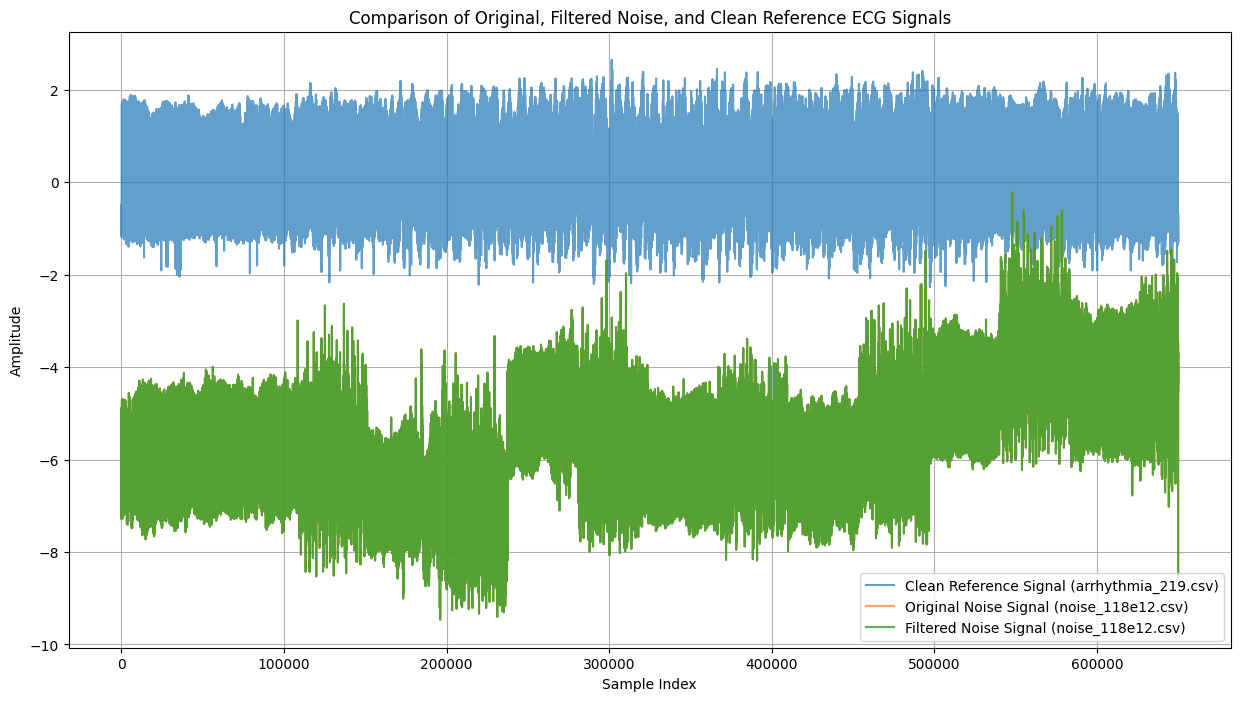

Visualisasi perbandingan sinyal selesai.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Asumsi variabel berikut sudah terdefinisi dari sel sebelumnya:
# original_noise_signal, filtered_noise_signal, clean_reference_signal
# sample_noise_file, sample_arrhythmia_file

# Pastikan sinyal memiliki panjang yang sama untuk plotting
min_len = min(len(original_noise_signal), len(filtered_noise_signal), len(clean_reference_signal))
original_noise_signal_plot = original_noise_signal[:min_len]
filtered_noise_signal_plot = filtered_noise_signal[:min_len]
clean_reference_signal_plot = clean_reference_signal[:min_len]

# Buat plot
plt.figure(figsize=(15, 8))

# Plot sinyal referensi "bersih" (Arrhythmia)
plt.plot(clean_reference_signal_plot, label=f'Clean Reference Signal ({sample_arrhythmia_file})', alpha=0.7)

# Plot sinyal noise asli - Tambahkan baris ini
plt.plot(original_noise_signal_plot, label=f'Original Noise Signal ({sample_noise_file})', alpha=0.7)

# Plot sinyal noise yang sudah difilter
plt.plot(filtered_noise_signal_plot, label=f'Filtered Noise Signal ({sample_noise_file})', alpha=0.8)


plt.title('Comparison of Original, Filtered Noise, and Clean Reference ECG Signals')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

print("Visualisasi perbandingan sinyal selesai.")

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# Load the full feature dataframe to ensure consistent labeling and indexing
INPUT_FEATURES_CSV = "/content/output/features/extracted_features.csv"
features_df_eval = pd.read_csv(INPUT_FEATURES_CSV)

# Extract original labels
y_eval_original = features_df_eval['label']
label_encoder_eval = LabelEncoder()
y_eval_encoded_full = label_encoder_eval.fit_transform(y_eval_original)

try:

    test_indices = X_test.index


    y_test_encoded_aligned = pd.Series(y_eval_encoded_full, index=features_df_eval.index).loc[test_indices]


    y_test_encoded_aligned = y_test_encoded_aligned.values


    print(f"Shape of X_test: {X_test.shape}")
    print(f"Shape of y_test_encoded_aligned: {y_test_encoded_aligned.shape}")

    if X_test.shape[0] != y_test_encoded_aligned.shape[0]:
        print("Error: Jumlah sampel X_test dan y_test_encoded_aligned tidak cocok!")
    else:
        # 1. Lakukan prediksi pada data uji X_test
        y_pred = clf.predict(X_test)

        print("Prediksi pada data uji selesai.")

        # 2. Hitung akurasi model
        accuracy = accuracy_score(y_test_encoded_aligned, y_pred)

        # 3. Cetak nilai akurasi
        print(f"\nAccuracy: {accuracy:.4f}")

        # 4. Hitung dan cetak metrik lain (precision, recall, F1-score)

        print("\nClassification Report:")

        target_names = label_encoder_eval.classes_
        print(classification_report(y_test_encoded_aligned, y_pred, target_names=target_names))

except Exception as e:
    print(f"An error occurred during evaluation: {e}")
    print("Please ensure X_test and clf are defined from previous steps.")

Shape of X_test: (26, 6)
Shape of y_test_encoded_aligned: (26,)
Prediksi pada data uji selesai.

Accuracy: 0.9231

Classification Report:
              precision    recall  f1-score   support

  arrhythmia       0.91      1.00      0.95        20
       noise       1.00      0.67      0.80         6

    accuracy                           0.92        26
   macro avg       0.95      0.83      0.88        26
weighted avg       0.93      0.92      0.92        26



In [ ]:
import pandas as pd
import numpy as np

# Pastikan X_test dan y_test_encoded memiliki jumlah sampel yang sama
if X_test.shape[0] != y_test_encoded.shape[0]:
    print("Error: Jumlah sampel X_test dan y_test_encoded tidak cocok. Harap jalankan kembali sel Data Splitting (8ef1eda5) dan Evaluation (348ef271).")
else:
    # 1. Lakukan prediksi label pada data uji
    y_pred_encoded = clf.predict(X_test)

    # 2. Lakukan prediksi probabilitas pada data uji
    y_pred_proba = clf.predict_proba(X_test) # Probabilitas untuk setiap kelas

    # 3. Konversi label encode kembali ke label asli (string)
    y_test_original = label_encoder_eval.inverse_transform(y_test_encoded)
    y_pred_original = label_encoder_eval.inverse_transform(y_pred_encoded)

    # 4. Buat DataFrame untuk menampilkan hasil
    # Dapatkan nama kelas asli dari label_encoder
    class_names = label_encoder_eval.classes_

    results_df = pd.DataFrame({
        'True Label': y_test_original,
        'Predicted Label': y_pred_original,
        f'Probability ({class_names[0]})': y_pred_proba[:, label_encoder_eval.transform([class_names[0]])[0]], # Probabilitas kelas 0
        f'Probability ({class_names[1]})': y_pred_proba[:, label_encoder_eval.transform([class_names[1]])[0]]  # Probabilitas kelas 1
    })

    # Tambahkan kolom untuk menunjukkan apakah prediksi benar atau salah
    results_df['Is Correct'] = results_df['True Label'] == results_df['Predicted Label']

    # Tampilkan tabel hasil
    print("Hasil Prediksi pada Data Uji:")
    display(results_df)

    print("\nRingkasan:")
    display(results_df['Is Correct'].value_counts())

Hasil Prediksi pada Data Uji:


,True Label,Predicted Label,Probability (arrhythmia),Probability (noise),Is Correct
0,arrhythmia,arrhythmia,0.61,0.39,True
1,arrhythmia,arrhythmia,0.88,0.12,True
2,noise,noise,0.05,0.95,True
3,noise,noise,0.25,0.75,True
4,arrhythmia,arrhythmia,0.94,0.06,True
5,arrhythmia,arrhythmia,1.00,0.00,True
6,arrhythmia,arrhythmia,0.99,0.01,True
7,arrhythmia,arrhythmia,0.77,0.23,True
8,arrhythmia,arrhythmia,0.96,0.04,True
9,arrhythmia,arrhythmia,1.00,0.00,True



Ringkasan:


,count
Is Correct,
True,24
False,2
